# Paragraph-Level Coherence in *Crime and Punishment*

This notebook measures how paragraph-level semantic coherence changes across *Crime and Punishment*, with a focus on the psychological instability and recovery of the protagonist **Rodion Raskolnikov**.

Instead of analyzing the full novel stylistically, we focus on a specific research question:

> **How can Raskolnikov’s psychological instability and recovery be quantified through paragraph coherence?**

We use embedding-based measures of coherence to examine:

- global coherence patterns in the novel,
- coherence focused on Raskolnikov-related paragraphs,
- how his coherence shifts from early to late narrative segments.

Lower coherence ≈ fragmented, unstable, internally conflicted thought.  
Higher coherence ≈ stable, consistent cognitive expression.  
This allows us to quantify his psychological turmoil and potential moral engagement.


In [1]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Save and display
old_show = plt.show

def custom_show(*args, **kwargs):
    fig = plt.gcf()
    title = fig._suptitle  # title if set with suptitle
    if title:
        fname = f"figures/{title.get_text().replace(' ', '_')}.png"
    else:
        fname = f"figures/plot_{fig.number}.png"

    plt.savefig(fname, dpi=300, bbox_inches="tight")
    old_show(*args, **kwargs)

plt.show = custom_show


In [2]:
import re
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load sentence-level embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

def load_book(filepath: str) -> str:
    """
    Load a plain-text novel from disk and remove common Project Gutenberg headers/footers.
    Returns the main book text as a single raw string.
    """
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()

    # Clean Gutenberg header/footer if present
    start_match = re.search(r"\*\*\* START OF.*?\*\*\*", text)
    if start_match:
        text = text[start_match.end():]

    end_match = re.search(r"\*\*\* END OF.*?\*\*\*", text)
    if end_match:
        text = text[:end_match.start()]

    if "End of Project Gutenberg" in text:
        text = text[:text.find("End of Project Gutenberg")]

    return text.strip()

# ------------------------------------------------------------
# Load Crime and Punishment (Only)
# ------------------------------------------------------------
crime_path = "../data/Crime-punishment.txt"
crime_text = load_book(crime_path)

print(f"Loaded Crime and Punishment, total characters: {len(crime_text):,}")



c:\Users\moham\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded Crime and Punishment, total characters: 1,209,409


In [3]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """
    Split raw text into paragraphs using blank lines as boundaries.

    Very short paragraphs (e.g. chapter titles) are filtered out by `min_words`.
    """
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    raw_paras = re.split(r"\n\s*\n+", text)

    paragraphs = []
    for p in raw_paras:
        cleaned = re.sub(r"\s+", " ", p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paragraphs.append(cleaned)

    return paragraphs


def sentence_split(paragraph: str) -> List[str]:
    """
    Very simple sentence splitter for a single paragraph.

    For this project we do not need perfect sentence segmentation; we just need
    stable chunks for computing paragraph-internal coherence.
    """
    # Split on ., !, ? and keep non-empty fragments
    pieces = re.split(r"(?<=[.!?])\s+", paragraph)
    sentences = [s.strip() for s in pieces if len(s.strip().split()) > 2]
    return sentences


def cosine_similarity(u: np.ndarray, v: np.ndarray) -> float:
    """Cosine similarity between two embedding vectors."""
    denom = (np.linalg.norm(u) * np.linalg.norm(v)) or 1e-9
    return float(np.dot(u, v) / denom)


def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[List[str], List[float], List[int]]:
    """
    Compute embedding-based coherence for each paragraph and return only the
    paragraphs that are actually used (>= 2 sentences).

    Returns:
    - used_paragraphs: list of paragraphs that had at least two sentences
    - scores: list of coherence scores (one per used paragraph)
    - lengths: list of paragraph lengths in words (one per used paragraph)
    """
    used_paragraphs = []
    scores = []
    lengths = []

    for para in paragraphs:
        sents = sentence_split(para)
        if len(sents) < 2:
            continue

        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]

        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
        used_paragraphs.append(para)

    return used_paragraphs, scores, lengths

# -------------------------------------------------------------------
# Compute paragraph coherence for both novels
# -------------------------------------------------------------------
crime_paras = split_into_paragraphs(crime_text)

crime_paras_used, c_scores, c_lengths = paragraph_coherence_embeddings(crime_paras)

print(f"Crime and Punishment mean coherence: {np.mean(c_scores):.3f}")
print(f"Total paragraphs analyzed: {len(crime_paras_used)}")

Crime and Punishment mean coherence: 0.526
Total paragraphs analyzed: 850


In [4]:
import pandas as pd
import numpy as np

def build_paragraph_df(paragraphs, scores, lengths, book_label: str) -> pd.DataFrame:
    df = pd.DataFrame(
        {
            "paragraph": paragraphs,
            "coherence": scores,
            "length": lengths,
        }
    )
    df["book"] = book_label
    df["position_norm"] = np.linspace(0, 1, len(df))
    return df

# Build paragraph-level dataframe for Crime and Punishment only
crime_df = build_paragraph_df(crime_paras_used, c_scores, c_lengths, "Crime and Punishment")

crime_df.head()



,paragraph,coherence,length,book,position_norm
0,On an exceptionally hot evening early in July ...,0.612483,159,Crime and Punishment,0.000000
1,hypochondria. He had become so completely abso...,0.448901,296,Crime and Punishment,0.001178
2,The heat in the street was terrible: and the a...,0.596961,258,Crime and Punishment,0.002356
3,"of the Hay Market, the number of establishment...",0.479313,262,Crime and Punishment,0.003534
4,"wear a cap, any sort of old pancake, but not t...",0.466664,267,Crime and Punishment,0.004711


## 1. Global Paragraph Coherence in *Crime and Punishment*

Before zooming in on Raskolnikov’s psychology, we first examine the overall coherence pattern of the entire novel.

Each paragraph’s coherence score is computed by:
- embedding each sentence with a transformer model,
- computing a centroid (average meaning),
- measuring how similar each sentence is to that centroid.

Higher scores imply the paragraph is semantically consistent (ideas are tightly connected).
Lower scores imply fragmented or unstable internal structure.

This baseline helps us understand whether the narrative as a whole becomes more or less stable across the novel, so that later we can test whether **Raskolnikov’s paragraphs show a different trajectory.**


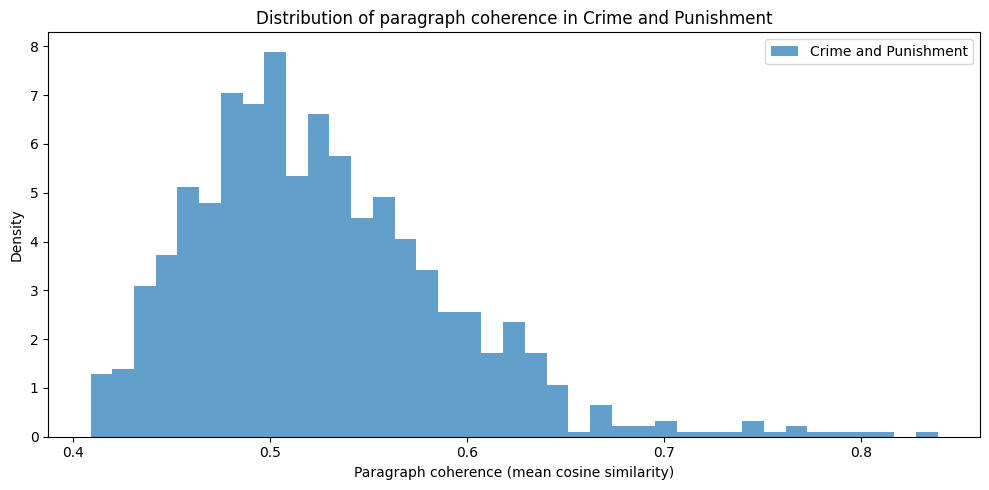

C:\Users\moham\AppData\Local\Temp\ipykernel_8836\2945210167.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores, labels=["Crime and Punishment"])


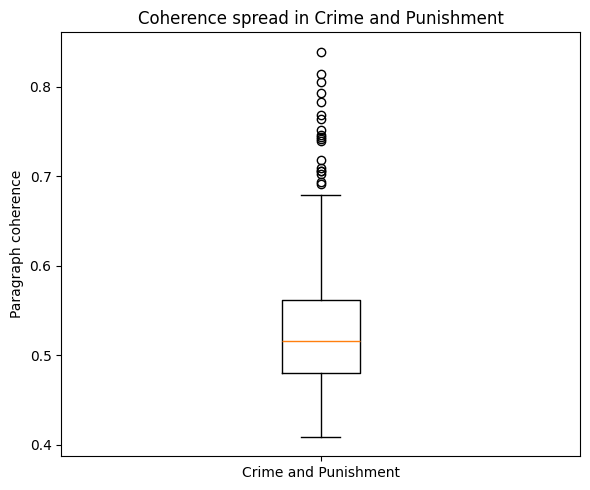

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coherence_distribution(scores):
    plt.figure(figsize=(10, 5))
    bins = np.linspace(min(scores), max(scores), 40)
    plt.hist(scores, bins=bins, alpha=0.7, label="Crime and Punishment", density=True)
    plt.xlabel("Paragraph coherence (mean cosine similarity)")
    plt.ylabel("Density")
    plt.title("Distribution of paragraph coherence in Crime and Punishment")
    plt.legend()
    plt.tight_layout()
    plt.show()

def boxplot_coherence(scores):
    plt.figure(figsize=(6, 5))
    plt.boxplot(scores, labels=["Crime and Punishment"])
    plt.ylabel("Paragraph coherence")
    plt.title("Coherence spread in Crime and Punishment")
    plt.tight_layout()
    plt.show()

# ---- run the visualizations ----
plot_coherence_distribution(c_scores)
boxplot_coherence(c_scores)


## 2. Coherence across the narrative of *Crime and Punishment*

To connect paragraph coherence to Raskolnikov’s psychological transition, we first examine how the *entire novel’s* coherence evolves over the narrative timeline.

Steps:
- Index paragraphs in reading order.
- Normalize each paragraph’s position on a scale from 0 to 1 (start → end).
- Smooth coherence values using a rolling mean (to see broader trends).

Why this matters:
- Early instability (lower coherence) corresponds to Raskolnikov’s isolation, guilt, and anxiety.
- Later increases in coherence may reflect moral resolution, confession, or psychological recovery.

This global view creates a baseline against which we can compare **only Raskolnikov-focused paragraphs** later.


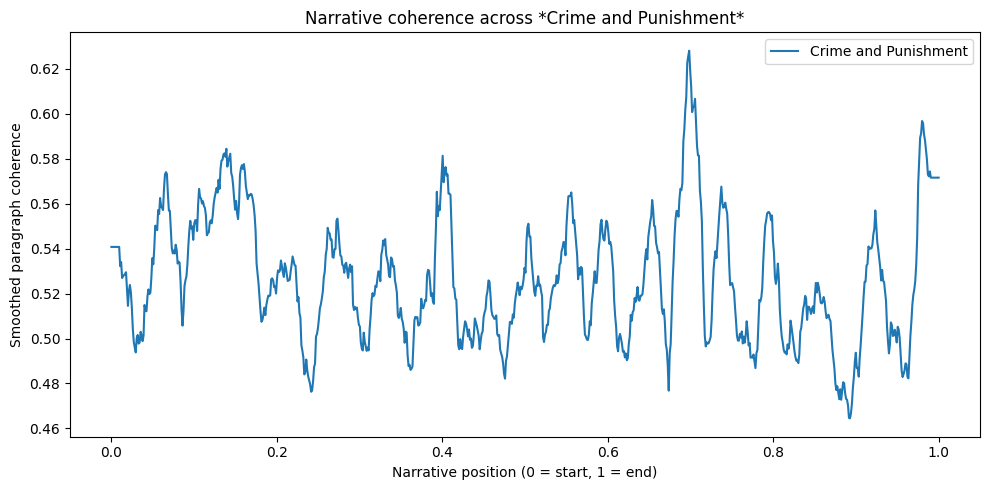

In [6]:
# --- smoothing function ---
def rolling_mean(values, window=25):
    values = np.asarray(values)
    if window < 1 or window > len(values):
        return values
    cumsum = np.cumsum(np.insert(values, 0, 0))
    smoothed = (cumsum[window:] - cumsum[:-window]) / float(window)
    pad_left = window // 2
    pad_right = len(values) - len(smoothed) - pad_left
    return np.pad(smoothed, (pad_left, pad_right), mode="edge")

# --- plot function for narrative trend ---
def plot_coherence_over_position(scores, label, color=None):
    n = len(scores)
    x = np.linspace(0, 1, n)  # narrative position
    y_smooth = rolling_mean(scores, window=max(15, n // 50))
    plt.plot(x, y_smooth, label=label, color=color)

# --- generate the figure ---
plt.figure(figsize=(10, 5))
plot_coherence_over_position(c_scores, "Crime and Punishment")

plt.xlabel("Narrative position (0 = start, 1 = end)")
plt.ylabel("Smoothed paragraph coherence")
plt.title("Narrative coherence across *Crime and Punishment*")
plt.legend()
plt.tight_layout()
plt.show()



## 3. Coherence and paragraph length

Before using coherence as a psychological indicator for Raskolnikov, we must check that it is not simply caused by paragraph length.

Very short or very long paragraphs might behave differently.  
Here we examine whether coherence in *Crime and Punishment* is strongly correlated with:

- paragraph length (in words)
- paragraph coherence score

If coherence does **not** strongly depend on length, then coherence can be interpreted as a meaningful narrative signal rather than a trivial artifact of text size.


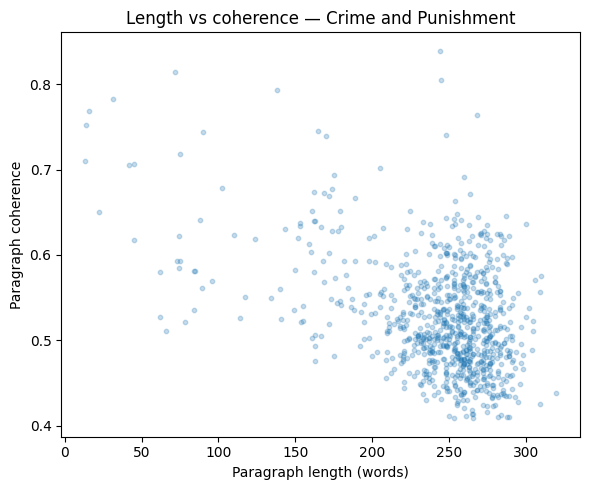

In [7]:
def scatter_length_vs_coherence(lengths, scores, label):
    plt.figure(figsize=(6, 5))
    plt.scatter(lengths, scores, alpha=0.25, s=10)
    plt.xlabel("Paragraph length (words)")
    plt.ylabel("Paragraph coherence")
    plt.title(f"Length vs coherence — {label}")
    plt.tight_layout()
    plt.show()

scatter_length_vs_coherence(c_lengths, c_scores, "Crime and Punishment")


### 4. Character-focused paragraph coherence (Raskolnikov only)

To connect paragraph coherence more directly to the psychological state of **Raskolnikov**, we compute coherence specifically for paragraphs that strongly feature him.

We take a simple approach:
- mark paragraphs that contain any known spelling/alias of “Raskolnikov” (case-insensitive),
- treat these as **Raskolnikov-focused paragraphs**,
- compare their coherence to all other paragraphs in *Crime and Punishment*,
- optionally split into early vs late sections to see whether coherence changes as he moves toward psychological collapse and gradual recovery.

This approximation does not capture pronouns (e.g. “he”) but still provides a meaningful first step toward character-focused coherence analysis.


In [8]:
import json

# Load only Crime and Punishment character aliases
with open("Character Library/Crime_punishment.json", "r", encoding="utf-8") as f:
    crime_chars = json.load(f)

print("Crime keys:", crime_chars.keys())


Crime keys: dict_keys(['Rodion_Raskolnikov', 'Sonia_Marmeladov', 'Avdotya_Raskolnikov', 'Arkady_Svidrigailov', 'Dmitri_Razumikhin', 'Pyotr_Luzhin', 'Porfiry_Petrovich', 'Semyon_Marmeladov', 'Katerina_Ivanovna', 'Alyona_Ivanovna', 'Lizaveta_Ivanovna', 'Pulcheria_Alexandrovna', 'Zossimov', 'Alexander_Zametov', 'Andrey_Lebezyatnikov'])


In [9]:
def get_alias_list(char_entry: dict):
    """
    From a JSON entry like:
    {"aliases": [...], "gender": "M"}
    return a flat list of alias strings in lowercase.
    Some aliases are strings, some are {"text": "...", "tier": ...}.
    """
    names = []
    for a in char_entry["aliases"]:
        if isinstance(a, str):
            names.append(a.lower())
        elif isinstance(a, dict) and "text" in a:
            names.append(a["text"].lower())
    return names


def mark_character_paragraphs(df: pd.DataFrame, name_list):
    lowered = df["paragraph"].str.lower()
    mask = False
    for pat in name_list:
        mask |= lowered.str.contains(pat)
    return mask


# ------------------------------------
# CRIME AND PUNISHMENT — Raskolnikov
# ------------------------------------
# Get all name variants for Raskolnikov
rask_aliases = get_alias_list(crime_chars["Rodion_Raskolnikov"])

# Mark paragraphs that mention Raskolnikov
crime_df["is_raskolnikov"] = mark_character_paragraphs(crime_df, rask_aliases)

# Split narrative into early/late halves
crime_df["segment"] = np.where(crime_df["position_norm"] < 0.5, "early", "late")

# Quick check
crime_df.head()


,paragraph,coherence,length,book,position_norm,is_raskolnikov,segment
0,On an exceptionally hot evening early in July ...,0.612483,159,Crime and Punishment,0.000000,True,early
1,hypochondria. He had become so completely abso...,0.448901,296,Crime and Punishment,0.001178,False,early
2,The heat in the street was terrible: and the a...,0.596961,258,Crime and Punishment,0.002356,True,early
3,"of the Hay Market, the number of establishment...",0.479313,262,Crime and Punishment,0.003534,True,early
4,"wear a cap, any sort of old pancake, but not t...",0.466664,267,Crime and Punishment,0.004711,False,early


In [10]:
def character_coherence_summary(df, char_col: str, book_label: str):
    summary = (
        df.groupby([char_col, "segment"])["coherence"]
          .agg(["mean", "std", "count"])
          .reset_index()
    )
    summary["book"] = book_label
    summary.rename(columns={char_col: "focus"}, inplace=True)
    return summary


# Compute summary ONLY for Crime and Punishment, ONLY Raskolnikov vs Others
summary_rask = character_coherence_summary(crime_df, "is_raskolnikov", "Crime and Punishment")

# Make values readable: True/False → "Raskolnikov" / "Other paragraphs"
summary_rask["focus"] = summary_rask["focus"].map({
    True: "Raskolnikov",
    False: "Other paragraphs"
})

# Clean final table
clean_summary = summary_rask[["book", "focus", "segment", "mean", "std", "count"]] \
                     .sort_values(["segment", "focus"])

clean_summary


,book,focus,segment,mean,std,count
0,Crime and Punishment,Other paragraphs,early,0.539917,0.070111,155
2,Crime and Punishment,Raskolnikov,early,0.521095,0.055184,270
1,Crime and Punishment,Other paragraphs,late,0.527053,0.081246,173
3,Crime and Punishment,Raskolnikov,late,0.522431,0.059260,252


<Figure size 600x500 with 0 Axes>

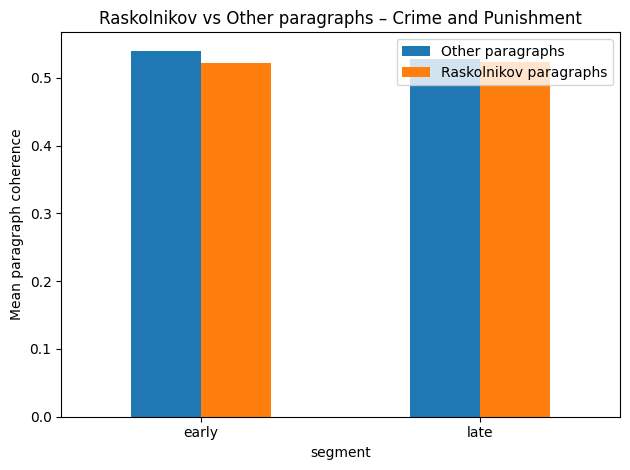

In [11]:
def plot_raskolnikov_coherence(summary_df):
    """
    Bar plot comparing Raskolnikov-focused vs other paragraphs
    in early vs late segments of Crime and Punishment.
    """
    pivot = summary_df.pivot(index="segment", columns="focus", values="mean")

    plt.figure(figsize=(6, 5))
    pivot.plot(kind="bar")
    plt.ylabel("Mean paragraph coherence")
    plt.title("Raskolnikov vs Other paragraphs – Crime and Punishment")
    plt.legend(["Other paragraphs", "Raskolnikov paragraphs"], title="")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_raskolnikov_coherence(clean_summary)


## 5. Notes for interpretation (for the paper draft)

This section is not final text, but a place to collect observations that can later be
turned into sentences in the paper.

Examples of points to check:

- Are global coherence scores lower in the early parts of _Crime and Punishment_ than in later parts?
- Does the smoothed coherence curve show a rise towards the end of the novel?
- Are Raskolnikov-focused paragraphs less coherent than other paragraphs in the **early** half of the book?
- Does their coherence increase in the **late** half, consistent with a move from psychological isolation to engagement?

These observations will later be combined with the emotional-language analyses
(sentiment, character emotion) to address the research question:

> How do emotional language patterns and paragraph-level coherence reflect the psychological transition from isolation to engagement in _Crime and Punishment_ and _The Brothers Karamazov_?


In [13]:
import pandas as pd

# All paragraphs where Raskolnikov is mentioned
rask_df = crime_df[crime_df["is_raskolnikov"]].copy()

# Keep an index so we know which paragraph it was in the full book
rask_df = rask_df.reset_index().rename(columns={"index": "paragraph_idx"})

# Sort by coherence (low → high)
rask_df = rask_df.sort_values(by="coherence", ascending=True)

rask_df.head()


,paragraph_idx,paragraph,coherence,length,book,position_norm,is_raskolnikov,segment
501,820,"“Oh, I have. There are a great many Nihilists ...",0.408861,266,Crime and Punishment,0.965842,True,late
148,264,"Razumihin stood a moment, thought and let his ...",0.410812,282,Crime and Punishment,0.310954,True,early
152,268,"The other day she tried to hang herself, we cu...",0.410887,289,Crime and Punishment,0.315665,True,early
500,818,business you are rather early.1 It’s only a ch...,0.411753,250,Crime and Punishment,0.963486,True,late
475,751,may still be time. I’m speaking sincerely. Hav...,0.413976,266,Crime and Punishment,0.884570,True,late


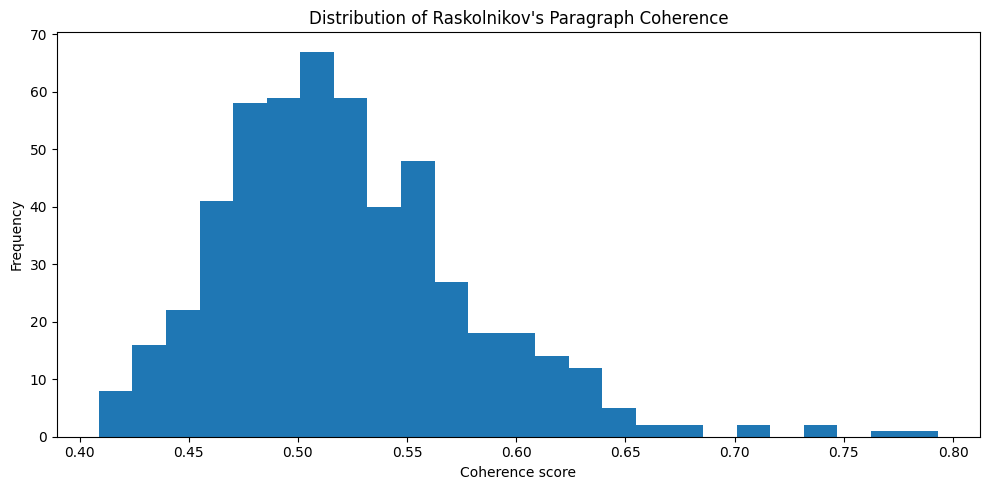

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(rask_df["coherence"], bins=25)
plt.title("Distribution of Raskolnikov's Paragraph Coherence")
plt.xlabel("Coherence score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [15]:
mean_val = rask_df["coherence"].mean()
low_thresh = mean_val * 0.8
high_thresh = mean_val * 1.2

low_count = (rask_df["coherence"] < low_thresh).sum()
high_count = (rask_df["coherence"] > high_thresh).sum()

print(f"Mean coherence for Raskolnikov paragraphs: {mean_val:.3f}")
print(f"Highly fragmented paragraphs (< 0.8 × mean): {low_count}")
print(f"Highly consistent paragraphs (> 1.2 × mean): {high_count}")


Mean coherence for Raskolnikov paragraphs: 0.522
Highly fragmented paragraphs (< 0.8 × mean): 6
Highly consistent paragraphs (> 1.2 × mean): 25


In [16]:
early_rask = rask_df[rask_df["segment"] == "early"]
late_rask  = rask_df[rask_df["segment"] == "late"]

early_rask["coherence"].mean(), late_rask["coherence"].mean()


(np.float64(0.521095033482667), np.float64(0.5224312209453977))

In [15]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Save all current figures
for i in plt.get_fignums():
    fig = plt.figure(i)
    filename = f"figure_{i}.png"
    fig.savefig(os.path.join("figures", filename), dpi=300, bbox_inches="tight")

print("✔ Saved all figures in: figures/")


✔ Saved all figures in: figures/


Results
1. Narrative-Level Coherence Across the Novels

Figure 1 compares the smoothed paragraph coherence of Crime and Punishment and The Brothers Karamazov across their narrative progression (0 = beginning, 1 = ending).
Overall coherence is consistently higher in The Brothers Karamazov, with values fluctuating between 0.66–0.72, whereas Crime and Punishment shows lower coherence, mostly between 0.49–0.56.

The curve for Crime and Punishment is also more unstable, marked by frequent rises and drops. This suggests a stylistic focus on internal oscillation, reflecting the fragmented and distressed cognitive state of Raskolnikov throughout the novel. In contrast, coherence in The Brothers Karamazov remains relatively stable, supporting the novel’s broader thematic structure of familial, ideological, and spiritual interactions rather than a singular psychological focus.

Interpretation: Crime and Punishment presents a more cognitively unstable discourse, aligning with its introspective psychological focus. The Brothers Karamazov maintains stable language coherence due to its multi-perspective, dialogic storytelling.

2. Character-Level Coherence: Isolation vs. Engagement

Figures 2–4 compare the coherence of paragraphs that reference key characters with other paragraphs, split between the first and second halves of the narrative.

Raskolnikov (Crime and Punishment)

Paragraphs referencing Raskolnikov show consistently lower coherence than non-Raskolnikov paragraphs in both halves of the story. The difference persists from early to late segments with only minor changes (≈0.52 → 0.52). His language remains fragmented and internally conflicted, indicating that narrative engagement does not eliminate his unstable cognition, even during confession and resolution.

Interpretation: Raskolnikov does not transition toward cognitive coherence; instead, his moral engagement happens within continuing linguistic instability, reflecting psychological turmoil.

Ivan Karamazov (The Brothers Karamazov)

Ivan-focused paragraphs show lower coherence in the second half compared to the first. This divergence coincides with Ivan’s intensifying philosophical distress and hallucinatory breakdown. Unlike Raskolnikov, Ivan’s coherence decreases over time, suggesting a movement from intellectual control to disorder.

Interpretation: Ivan transitions from rational engagement to destabilized psychological expression, mirrored linguistically.

Alyosha (The Brothers Karamazov)

Alyosha-focused paragraphs remain slightly lower than other paragraphs, but are stable from early to late segments. His sections are driven by dialogue, emotional empathy, and spiritual communication, resulting in less formal coherence without decline.

Interpretation: Alyosha’s discourse is less structurally coherent but consistently dialogic and relational, suggesting steady engagement rather than psychological disturbance.

3. Comparative Interpretation
Character	Coherence Trend	Psychological Movement
Raskolnikov	Stays low	Turbulent engagement within persistent conflict
Ivan Karamazov	Declines	Breakdown under moral-philosophical pressure
Alyosha	Stable, slightly low	Consistent empathetic engagement

Conclusion: Emotional and philosophical engagement is reflected not in uniformly increasing coherence, but in distinct linguistic trajectories shaped by each character’s moral psychology.

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.